# Importing Dataset and Libraries

In [128]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import warnings

# Load the NIST handwritten digit dataset
digits = load_digits()

# Convert the dataset to a DataFrame for easier manipulation
data = pd.DataFrame(data=digits.data, columns=[f'pixel_{i}' for i in range(digits.data.shape[1])])
data['target'] = digits.target

# Standardize the data for better performance with SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(digits.data)
y = digits.target

In [169]:
# Choose an example digit (e.g., index 0)
index = 0
digit = digits.images[index]  # 8x8 image

# Print label
print(f"Label: {digits.target[index]}")
print("Pixel values:")

# Print pixel values as a table
for row in digit:
    print(" ".join(f"{int(val):2d}" for val in row))

Label: 0
Pixel values:
 0  0  5 13  9  1  0  0
 0  0 13 15 10 15  5  0
 0  3 15  2  0 11  8  0
 0  4 12  0  0  8  8  0
 0  5  8  0  0  9  8  0
 0  4 11  0  1 12  7  0
 0  2 14  5 10 12  0  0
 0  0  6 13 10  0  0  0


# Dimension Reductionality Techniques

# TSNE

Nonlinear, not suitable for SVM classifier

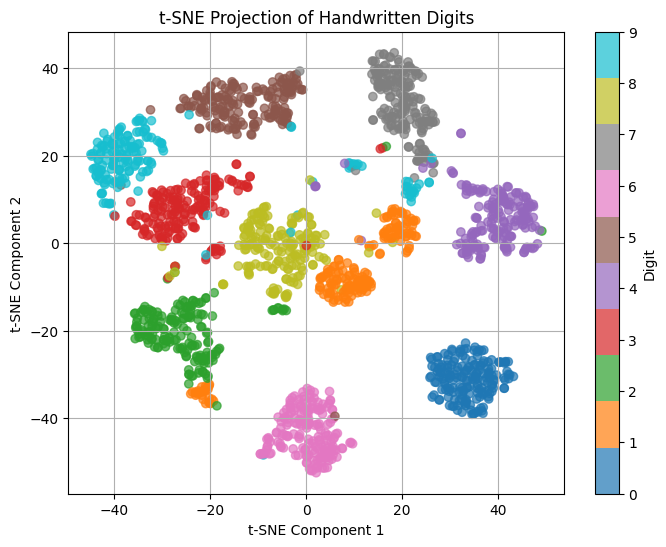

In [129]:
from sklearn.manifold import TSNE

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot the t-SNE projection
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection of Handwritten Digits')
plt.colorbar(label='Digit')
plt.grid(True)
plt.show()


# PCA & UMAP

Explain PCA & UMAP here

In [136]:
import warnings
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import umap.umap_ as umap

def find_best_dimensionality(X, y, max_dim=64, method="PCA"):
    """
    Finds the best dimensionality for either PCA or UMAP based on SVM performance.

    Parameters:
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        max_dim (int): Maximum number of dimensions to test.
        method (str): Dimensionality reduction method ("PCA" or "UMAP").

    Returns:
        best_n_components (int): Best number of components based on cross-validation score.
        best_fitted_n_components (int): Best number of components based on smallest train-test score difference.
        scores (list): Cross-validation scores for each dimensionality.
        overfitting_check (list): Train and test scores for each dimensionality.
    """
    best_score = 0
    best_n_components = 0
    scores = []
    overfitting_check = []
    smallest_diff = float('inf')
    best_fitted_n_components = 0

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for n_components in range(1, max_dim + 1):
        warnings.filterwarnings("ignore")

        print(f"Testing {method} with {n_components} components")

        # Apply the chosen dimensionality reduction method
        if method == "PCA":
            model = PCA(n_components=n_components, random_state=42)
        elif method == "UMAP":
            model = umap.UMAP(n_components=n_components, random_state=42)
        else:
            raise ValueError("Invalid method. Choose 'PCA' or 'UMAP'.")

        X_train_reduced = model.fit_transform(X_train)
        X_test_reduced = model.transform(X_test)

        # Train an SVM classifier
        svm_clf = svm.SVC(kernel='linear')
        svm_clf.fit(X_train_reduced, y_train)

        # Evaluate performance on training and testing sets
        train_score = svm_clf.score(X_train_reduced, y_train)
        test_score = svm_clf.score(X_test_reduced, y_test)
        overfitting_check.append((n_components, train_score, test_score))

        # Check for the smallest difference between train and test scores
        score_diff = abs(train_score - test_score)
        if score_diff < smallest_diff:
            smallest_diff = score_diff
            best_fitted_n_components = n_components

        # Use cross-validation for overall score
        score = cross_val_score(svm_clf, X_train_reduced, y_train, cv=5).mean()
        scores.append(score)

        if score > best_score:
            best_score = score
            best_n_components = n_components

    # Print overfitting check results
    for n_components, train_score, test_score in overfitting_check:
        print(f"Components: {n_components}, Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")

    return best_n_components, best_fitted_n_components, scores, overfitting_check

In [ ]:

def plot_dimensionality_results(method, best_n_components, best_fitted_n_components, scores, overfitting_results):
    """
    Plots the results of dimensionality reduction (PCA or UMAP) and SVM performance.

    Parameters:
        method (str): Dimensionality reduction method ("PCA" or "UMAP").
        best_n_components (int): Best number of components based on cross-validation score.
        best_fitted_n_components (int): Best number of components based on smallest train-test score difference.
        scores (list): Cross-validation scores for each dimensionality.
        overfitting_results (list): Train and test scores for each dimensionality.
    """
    print(f"Best number of {method} components: {best_n_components}")
    print(f"Score ({best_n_components}): {max(scores):.4f}")

    # Plot the scores for each number of components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b', label='Cross-Validation Scores')

    # Highlight the best component number
    plt.scatter(best_n_components, max(scores), color='red', label='Best Component', zorder=5)
    plt.annotate(f'Best: {best_n_components}\nScore: {max(scores):.4f}', 
                 (best_n_components, max(scores)), 
                 textcoords="offset points", 
                 xytext=(10, -40), 
                 ha='center', color='red')

    # Add a horizontal line at the best score
    plt.axhline(y=max(scores), color='red', linestyle='--', label='Best Score')

    # Add labels and grid
    plt.title(f'SVM Performance vs. {method} Components')
    plt.xlabel(f'Number of {method} Components')
    plt.ylabel('Cross-Validation Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot test score vs. training score for each dimension
    train_scores = [result[1] for result in overfitting_results]
    test_scores = [result[2] for result in overfitting_results]

    # Find the best-fitted component (smallest train-test difference)
    best_fitted_index = best_fitted_n_components  # Adjust for 0-based index
    best_fitted_train_score = train_scores[best_fitted_index]
    best_fitted_test_score = test_scores[best_fitted_index]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_scores) + 1), train_scores, marker='o', linestyle='-', color='g', label='Training Score')
    plt.plot(range(1, len(test_scores) + 1), test_scores, marker='o', linestyle='-', color='orange', label='Test Score')

    # Highlight the best-fitted component
    plt.scatter(best_fitted_n_components, best_fitted_train_score, color='red', label='Best Fitted', zorder=5)
    plt.annotate(f'Best Fitted: {best_fitted_n_components}\nTrain: {best_fitted_train_score:.4f}\nTest: {best_fitted_test_score:.4f}', 
                 (best_fitted_n_components, best_fitted_test_score), 
                 textcoords="offset points", 
                 xytext=(10, -70), 
                 ha='center', color='red')

    # Add labels and grid
    plt.title(f'Training vs. Test Score for Each {method} Dimension')
    plt.xlabel(f'Number of {method} Components')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot test score for each dimension
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(test_scores) + 1), test_scores, marker='o', linestyle='-', color='purple', label='Test Score')

    # Highlight the best component number
    best_test_score = max(test_scores)
    best_test_index = test_scores.index(best_test_score) + 1
    plt.scatter(best_test_index, best_test_score, color='red', label='Best Test Score', zorder=5)
    plt.annotate(f'Best: {best_test_index}\nTest Score: {best_test_score:.4f}', 
                 (best_test_index, best_test_score), 
                 textcoords="offset points", 
                 xytext=(10, -40), 
                 ha='center', color='red')

    # Add labels and grid
    plt.title(f'Test Score for Each {method} Dimension')
    plt.xlabel(f'Number of {method} Components')
    plt.ylabel('Test Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## PCA

In [174]:
# Find the best number of components for the SVM classifier (PCA)
best_n_components_pca, best_fitted__components_pca, scores_pca, overfitting_results_pca = find_best_dimensionality(X_scaled, y, method="PCA")

Testing PCA with 1 components
Testing PCA with 2 components
Testing PCA with 3 components
Testing PCA with 4 components
Testing PCA with 5 components
Testing PCA with 6 components
Testing PCA with 7 components
Testing PCA with 8 components
Testing PCA with 9 components
Testing PCA with 10 components
Testing PCA with 11 components
Testing PCA with 12 components
Testing PCA with 13 components
Testing PCA with 14 components
Testing PCA with 15 components
Testing PCA with 16 components
Testing PCA with 17 components
Testing PCA with 18 components
Testing PCA with 19 components
Testing PCA with 20 components
Testing PCA with 21 components
Testing PCA with 22 components
Testing PCA with 23 components
Testing PCA with 24 components
Testing PCA with 25 components
Testing PCA with 26 components
Testing PCA with 27 components
Testing PCA with 28 components
Testing PCA with 29 components
Testing PCA with 30 components
Testing PCA with 31 components
Testing PCA with 32 components
Testing PCA with 

Best number of PCA components: 51
Score (51): 0.9742


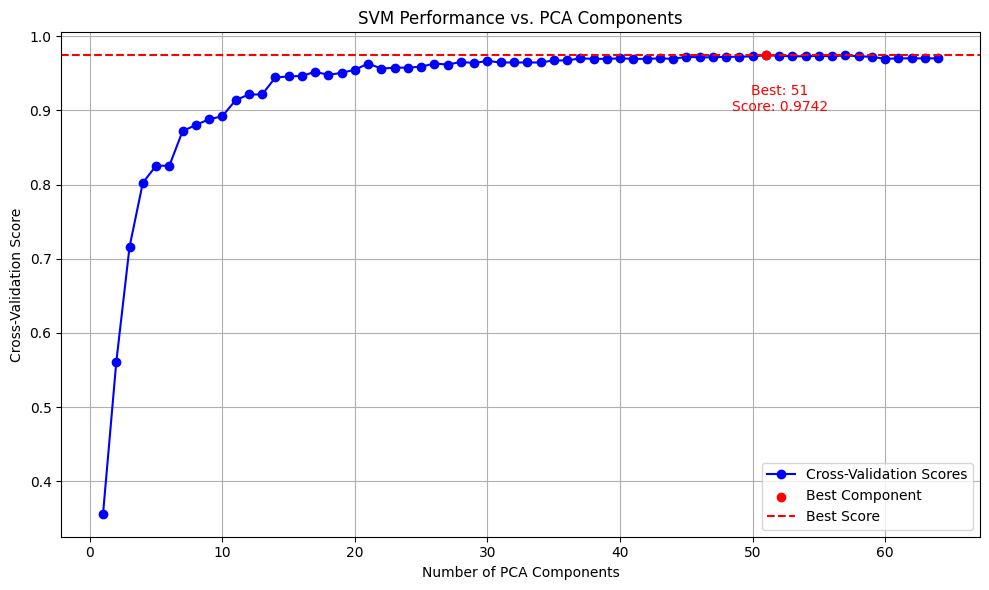

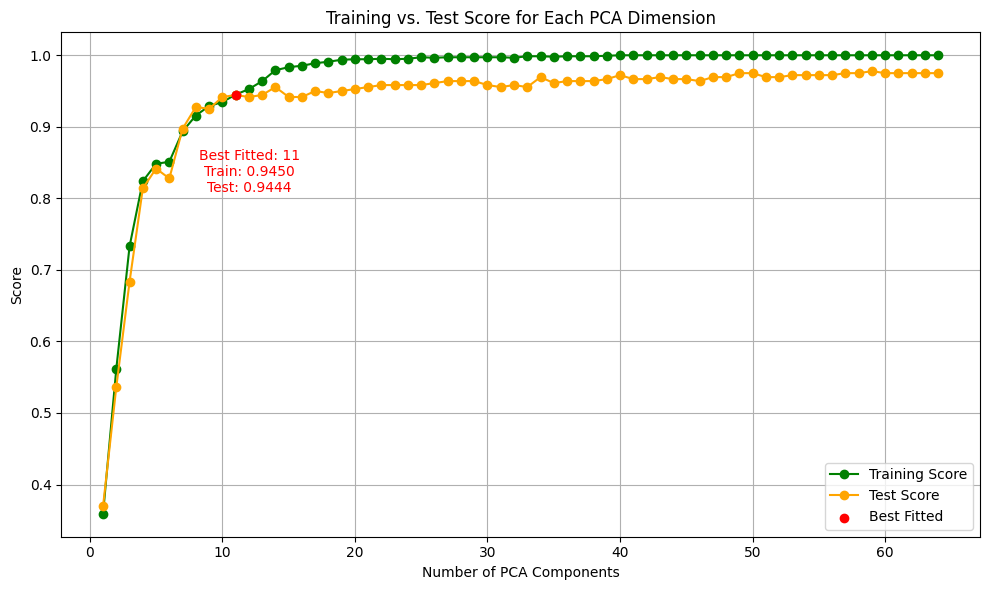

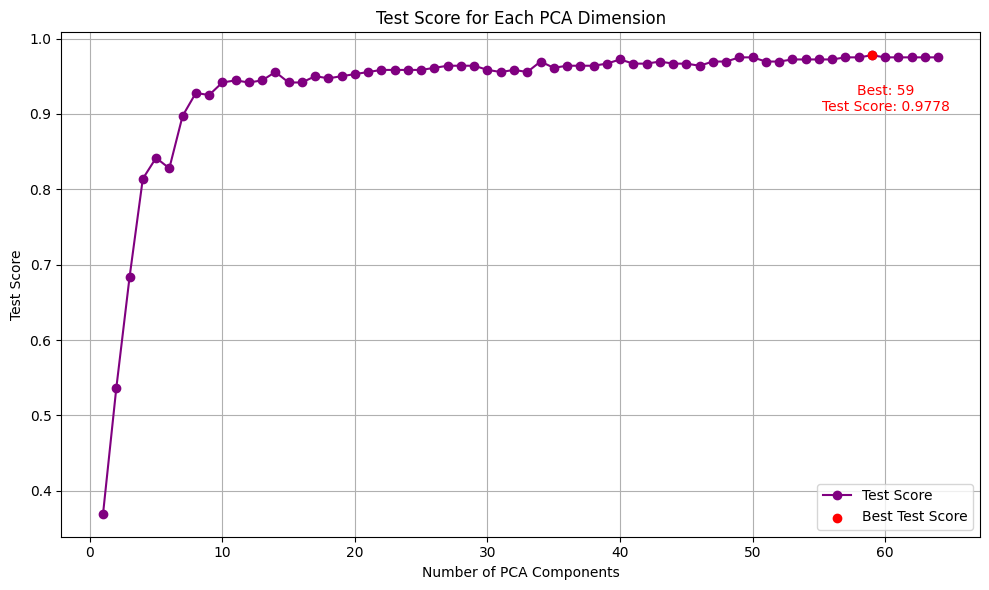

In [177]:
plot_dimensionality_results(
    method="PCA",
    best_n_components=best_n_components_pca,
    best_fitted_n_components=best_fitted_n_components_pca,
    scores=scores_pca,
    overfitting_results=overfitting_results_pca
)

## UMAP

In [168]:
# Find the best number of components for the SVM classifier (UMAP)
best_n_components_umap, best_fitted_n_components_umap, scores_umap, overfitting_results_umap = find_best_dimensionality(X_scaled, y, method="UMAP")

Testing UMAP with 1 components
Testing UMAP with 2 components
Testing UMAP with 3 components
Testing UMAP with 4 components
Testing UMAP with 5 components
Testing UMAP with 6 components
Testing UMAP with 7 components
Testing UMAP with 8 components
Testing UMAP with 9 components
Testing UMAP with 10 components
Testing UMAP with 11 components
Testing UMAP with 12 components
Testing UMAP with 13 components
Testing UMAP with 14 components
Testing UMAP with 15 components
Testing UMAP with 16 components
Testing UMAP with 17 components
Testing UMAP with 18 components
Testing UMAP with 19 components
Testing UMAP with 20 components
Testing UMAP with 21 components
Testing UMAP with 22 components
Testing UMAP with 23 components
Testing UMAP with 24 components
Testing UMAP with 25 components
Testing UMAP with 26 components
Testing UMAP with 27 components
Testing UMAP with 28 components
Testing UMAP with 29 components
Testing UMAP with 30 components
Testing UMAP with 31 components
Testing UMAP with

Best number of UMAP components: 17
Score (17): 0.9736


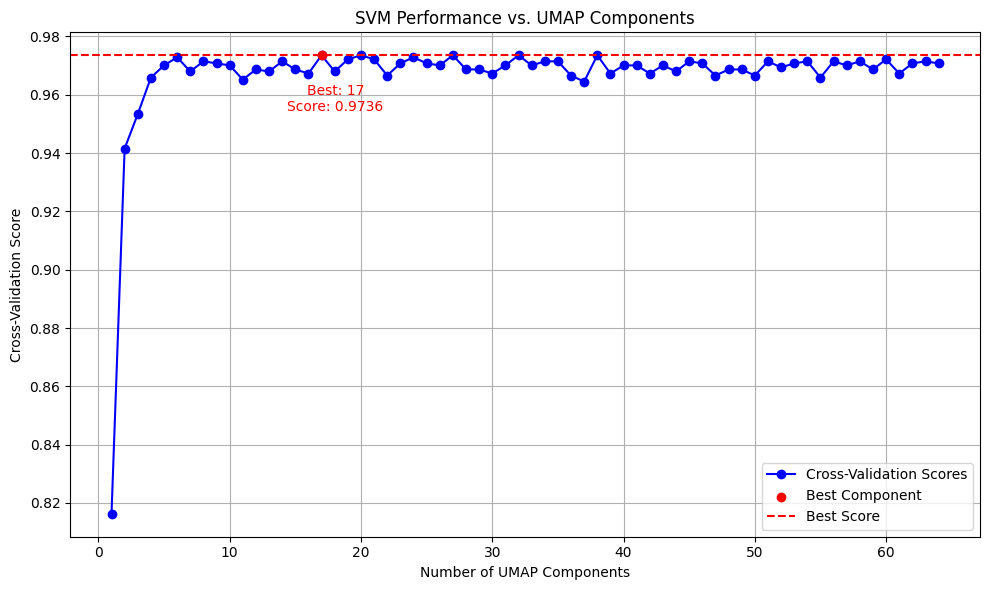

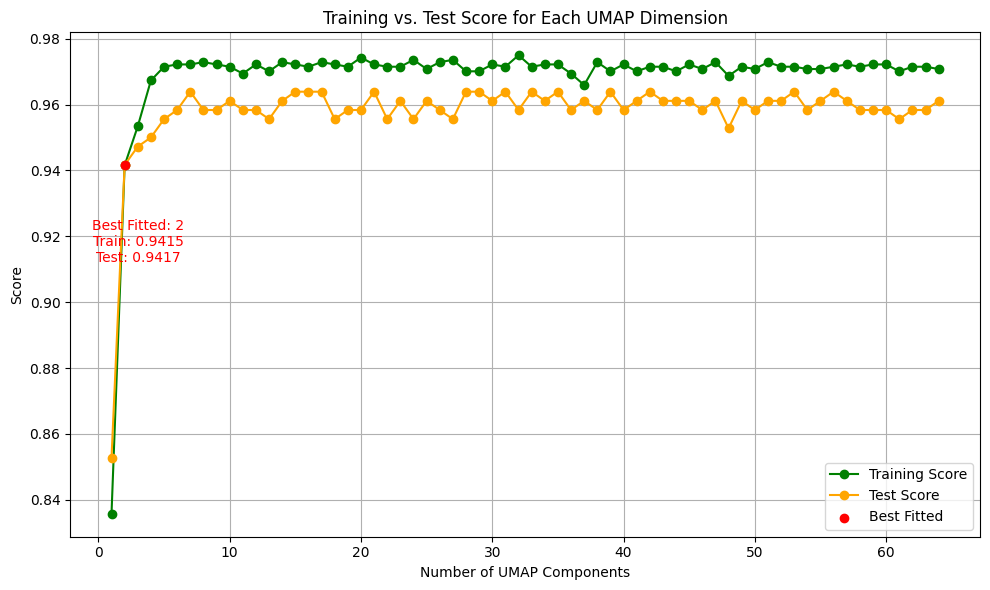

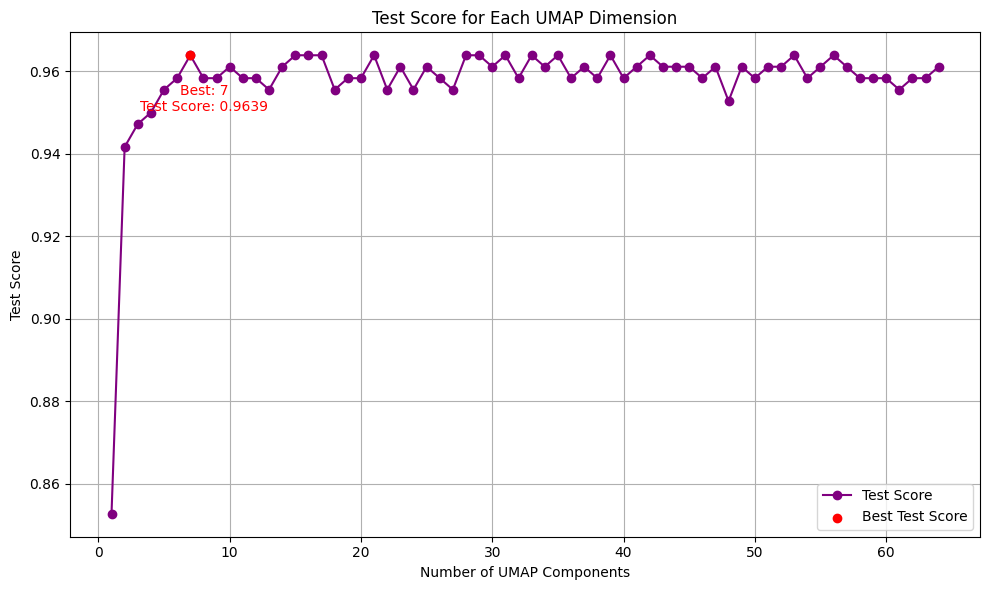

In [176]:
plot_dimensionality_results(
    method="UMAP",
    best_n_components=best_n_components_umap,
    best_fitted_n_components=best_fitted_n_components_umap,
    scores=scores_umap,
    overfitting_results=overfitting_results_umap
)

### PCA and UMAP Projections

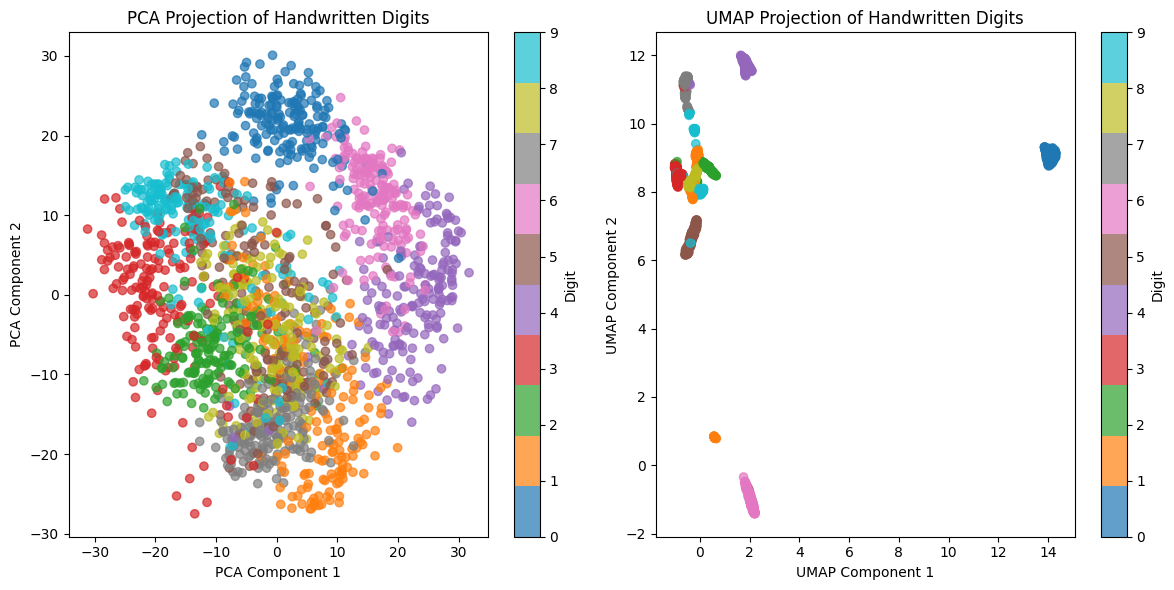

In [68]:
import matplotlib.pyplot as plt

# Step 3: Plot PCA Projection
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Creates a subplot (1 row, 2 columns, first plot)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Handwritten Digits')
plt.colorbar(label='Digit')

# Step 4: Plot UMAP Projection
plt.subplot(1, 2, 2)  # Second plot in the subplot grid
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Handwritten Digits')
plt.colorbar(label='Digit')

# Step 5: Display the plots
plt.tight_layout()

plt.show()

### Setup Model

In [55]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


### Hyperparameter Tuning (C)

In [56]:
c_values = range(1, 10)

# Use this to store our results
scores = np.ones((len(c_values), 5))

for (i, c_candidate) in enumerate(c_values):
    print("Cross validating for %d..." % c_candidate)

    # Initializing our model with the given C value
    model = LinearSVC(C=c_candidate, random_state=42, max_iter=10000, dual='auto')
    current_scores = cross_val_score(model, X_train, y_train, cv=5)
    scores[i] = current_scores

Cross validating for 1...
Cross validating for 2...
Cross validating for 3...
Cross validating for 4...
Cross validating for 5...
Cross validating for 6...
Cross validating for 7...
Cross validating for 8...
Cross validating for 9...


### Figure 3

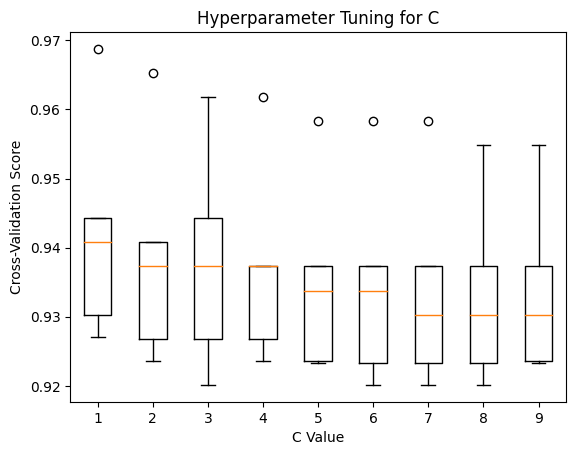

In [39]:
plt.boxplot(scores.T)
plt.title('Hyperparameter Tuning for C')
plt.xlabel('C Value')
plt.ylabel('Cross-Validation Score')
plt.show()

### Testing Model With Optimal C Value

In [43]:
# Setting up our model with the optimal C value (e.g., 1)
model = LinearSVC(C=1, dual='auto')

# Compute both training and test scores
cv_results = cross_validate(model, X_train, y_train, cv=5, return_train_score=True)

# Access training and test scores
train_scores = cv_results['train_score']
test_scores = cv_results['test_score']

# Display scores
print("Train Score (median): ", np.median(train_scores))
print("Test Score (median): ", np.median(test_scores))

Train Score (median):  0.9982593559617058
Test Score (median):  0.9407665505226481


# TestingIGNORE

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        53
           1       0.09      0.32      0.14        50
           2       0.63      0.40      0.49        47
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00        60
           5       0.26      0.36      0.30        66
           6       0.00      0.00      0.00        53
           7       0.00      0.00      0.00        55
           8       0.01      0.02      0.02        43
           9       0.08      0.05      0.06        59

    accuracy                           0.21       540
   macro avg       0.21      0.21      0.20       540
weighted avg       0.20      0.21      0.20       540

Accuracy: 0.20925925925925926


c:\Users\qoste\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\qoste\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\qoste\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

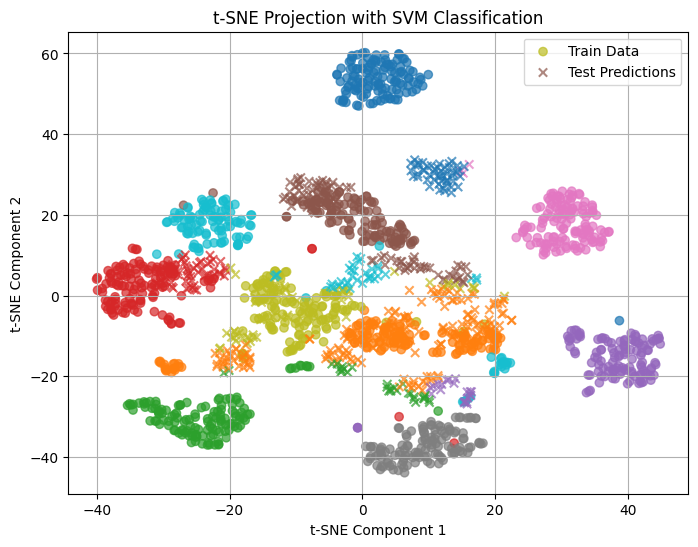

In [104]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

# Train an SVM classifier on the t-SNE reduced data
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tsne, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_tsne)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot the t-SNE projection with SVM decision boundaries
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.7, label='Train Data')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_pred, cmap='tab10', alpha=0.7, marker='x', label='Test Predictions')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection with SVM Classification')
plt.legend()
plt.grid(True)
plt.show()